### Deep Q Network for navigating through a grid world with different goal locations with fixed obstacles
#### Reward system 2: As per the paper - "Autonomous Navigation of an AMR using Deep Reinforcement Learning in a Warehouse Environment" (Episode terminates if the bot hits the bounds or obstacles)

##### Final model name: 

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

2023-07-25 09:54:24.283890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 09:54:24.857583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# print gpu info
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-25 09:54:26.653727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 09:54:26.669106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 09:54:26.669268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Create a neural network model
def create_model(input_shape, num_actions):
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_actions, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0008))
    return model

In [4]:
# Create a class for the environment
class Env():
    def __init__(self, grid_size=6, max_steps=500):
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.goal = np.random.randint(0, grid_size, size=2) # random goal
        print('Goal:', self.goal)
        
        self.obstacles = np.array([[2,2], [2,3], [3,4], [5,2]])

        # self.rewards = np.zeros((grid_size, grid_size))
        self.reset()

    def reset(self):
        self.pos = np.random.randint(0, self.grid_size, size=2)
        while self.pos in self.obstacles:
            self.pos = np.random.randint(0, self.grid_size, size=2)
        self.steps = 0
        self.done = False
        return self.pos
    
    def reset_goal(self):
        self.goal = np.random.randint(0, self.grid_size, size=2)
        while self.goal in self.obstacles:
            self.goal = np.random.randint(0, self.grid_size, size=2)
        print('Goal:', self.goal)
        # for i in range(self.grid_size):
        #     for j in range(self.grid_size):
        #         self.rewards[i, j] = -self.euclidean_distance_from_goal(np.array([i, j]))
        # self.rewards[self.goal[0], self.goal[1]] = 100
        return self.goal
    
    # def step(self, action):
    #     self.steps += 1
    #     if action == 0 and self.pos[0] < self.grid_size - 1: # right
    #         self.pos[0] += 1
    #     elif action == 1 and self.pos[0] > 0: # left
    #         self.pos[0] -= 1
    #     elif action == 2 and self.pos[1] > 0: # down
    #         self.pos[1] -= 1
    #     elif action == 3 and self.pos[1] < self.grid_size - 1: # up
    #         self.pos[1] += 1
    #     else:
    #         pass
    #         # raise ValueError('Invalid action')
    #     if np.array_equal(self.pos, self.goal):
    #         self.done = True
    #         reward = 0
    #         # reward = 100
    #     elif self.steps >= self.max_steps:
    #         self.done = True
    #         reward = self.rewards[self.pos[0], self.pos[1]]
    #     else:
    #         reward = self.rewards[self.pos[0], self.pos[1]]
    #     return self.pos, reward, self.done

    def step(self, action): # As per the paper
        self.steps += 1
        prev_pos = self.pos.copy()
        if action == 0 and self.pos[0] < self.grid_size - 1 and not (self.pos + np.array([1, 0])) in self.obstacles: # right
            self.pos[0] += 1
        elif action == 1 and self.pos[0] > 0 and not (self.pos - np.array([1, 0])) in self.obstacles: # left
            self.pos[0] -= 1
        elif action == 2 and self.pos[1] > 0 and not (self.pos - np.array([0, 1])) in self.obstacles: # down
            self.pos[1] -= 1
        elif action == 3 and self.pos[1] < self.grid_size - 1 and not (self.pos + np.array([0, 1])) in self.obstacles: # up
            self.pos[1] += 1
        else:
            reward = -150
            self.done = True
            return self.pos, reward, self.done, True # TODO: The episode is not terminated.
        if np.array_equal(self.pos, self.goal):
            self.done = True
            reward = 500
        elif self.steps >= self.max_steps:
            self.done = True
            reward = 0
        else:
            if self.euclidean_distance_from_goal(self.pos) < self.euclidean_distance_from_goal(prev_pos):
                reward = 10
            else:
                reward = -10
        return self.pos, reward, self.done, False
        

    def euclidean_distance_from_goal(self, pos):
        dist = np.sqrt(np.sum((pos - self.goal) ** 2))
        return dist
        
        

In [5]:
# Create an agent class
class Agent():
    def __init__(self, env, model, target_model):
        self.env = env
        self.model = model
        self.target_model = target_model
        self.target_model.set_weights(self.model.get_weights())
        self.gamma = 0.7
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.001
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        

    def add_to_memory(self, state, goal, action, reward, next_state, done):
        self.memory.append((state, goal, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 4)
        else:
            # Pre-process the input
            inputt = np.concatenate((state, self.env.goal))
            inputt = tf.convert_to_tensor(inputt)
            inputt = tf.expand_dims(inputt, 0)

            return np.argmax(self.model.predict(inputt, verbose=0)[0]) # TODO: check the predict output

    def predict(self, inputt):

        return np.argmax(self.model.predict(inputt, verbose=0)[0])

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, goal, action, reward, next_state, done in batch:
            
            target = reward

            if not done:
                # Pre-process the next state input
                input_next = np.concatenate((next_state, goal))
                input_next = tf.convert_to_tensor(input_next)
                input_next = tf.expand_dims(input_next, 0)

                target += self.gamma * np.amax(self.target_model.predict(input_next, verbose=0)[0])

            # Pre-process the current state input
            inputt = np.concatenate((state, goal))
            inputt = tf.convert_to_tensor(inputt)
            inputt = tf.expand_dims(inputt, 0)

            cur_q_value = self.model.predict(inputt, verbose=0) # Q-value of current state
            cur_q_value[0][action] = target # TODO: check the predict output
            
            self.model.fit(inputt, cur_q_value, epochs=1, verbose=0)
            

In [6]:
# Initialize the agent

try:
    model = tf.keras.models.load_model('doublenet_dqn_diff_start_diff_goal_obst.h5')
    print("Loaded model from disk")
    agent = Agent(Env(), model=model, target_model=model)
except:
    print("Creating new model")
    agent = Agent(Env(), model=create_model(input_shape=(4,), num_actions=4), target_model=create_model(input_shape=(4,), num_actions=4))


2023-07-25 09:54:26.823506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Creating new model
Goal: [1 5]


2023-07-25 09:54:26.823688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 09:54:26.823794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 09:54:26.864982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
# Train the agent

num_episodes = 500
# num_episodes = 5
reward_lst = []

file = open('rewards.txt', 'a')

for episode in range(num_episodes):
    state_lst = [] # DEBUG
    ep_reward = 0 # DEBUG
    state = agent.env.reset()
    for step in range(agent.env.max_steps):
        state_lst.append(state.copy()) # DEBUG
        # print('State:', state) # DEBUG
        # print('state_lst:', state_lst) # DEBUG
        action = agent.act(state)
        # print('Action:', action) # DEBUG
        next_state, reward, done, terminate = agent.env.step(action)
        ep_reward += reward # DEBUG
        # print(f"next_state: {next_state}, reward: {reward}, done: {done}") # DEBUG
        # next_state = np.reshape(next_state, [1, 2])
        agent.add_to_memory(state, agent.env.goal, action, reward, next_state, done)
        state = next_state
        if done:
            if np.array_equal(agent.env.goal, agent.env.pos): # Reached the goal
                agent.env.reset_goal()
            if (agent.env.steps >= agent.env.max_steps) or terminate:
                print('Episode: {}/{}, steps: {}, e: {:.2}'.format(episode, num_episodes, step+1, agent.epsilon))
                print('State list:', state_lst) # DEBUG
                break
    if len(agent.memory) > agent.batch_size:
        agent.replay()
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = (1 - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode) + agent.epsilon_min
    if episode % 5 == 0:
        agent.model.save('doublenet_dqn_diff_start_diff_goal_obst.h5')    
    agent.target_model.set_weights(agent.model.get_weights())

    reward_lst.append(ep_reward) # DEBUG
    file.write(f"{episode},{ep_reward}\n") # DEBUG
    file.flush() # DEBUG
    
print('Average reward:', np.mean(reward_lst))

Episode: 0/500, steps: 4, e: 1.0
State list: [array([1, 1]), array([1, 0]), array([0, 0]), array([0, 1])]
Episode: 1/500, steps: 1, e: 1.0
State list: [array([0, 5])]
Episode: 2/500, steps: 2, e: 1.0
State list: [array([4, 1]), array([4, 0])]
Episode: 3/500, steps: 1, e: 1.0
State list: [array([4, 1])]
Episode: 4/500, steps: 1, e: 1.0
State list: [array([0, 0])]
Episode: 5/500, steps: 3, e: 1.0
State list: [array([0, 0]), array([0, 1]), array([0, 0])]
Episode: 6/500, steps: 1, e: 1.0
State list: [array([4, 5])]
Episode: 7/500, steps: 1, e: 0.99
State list: [array([0, 0])]
Goal: [4 5]
Episode: 8/500, steps: 1, e: 0.99
State list: [array([1, 5])]
Episode: 9/500, steps: 1, e: 0.99
State list: [array([0, 0])]
Goal: [1 0]
Episode: 10/500, steps: 1, e: 0.99
State list: [array([4, 5])]
Episode: 11/500, steps: 1, e: 0.99
State list: [array([4, 5])]
Episode: 12/500, steps: 1, e: 0.99
State list: [array([4, 5])]
Goal: [1 5]
Episode: 13/500, steps: 1, e: 0.99
State list: [array([1, 0])]
Episode: 

2023-07-25 09:54:27.335747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-25 09:54:27.832401: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f34ac2c8c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-25 09:54:27.832422: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-07-25 09:54:27.835336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-25 09:54:27.845923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-25 09:54:27.891006: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older

Episode: 48/500, steps: 4, e: 0.96
State list: [array([0, 1]), array([1, 1]), array([0, 1]), array([1, 1])]
Goal: [4 1]
Episode: 49/500, steps: 5, e: 0.96
State list: [array([0, 1]), array([0, 0]), array([1, 0]), array([0, 0]), array([1, 0])]
Episode: 50/500, steps: 1, e: 0.96
State list: [array([0, 1])]
Episode: 51/500, steps: 1, e: 0.96
State list: [array([1, 5])]
Episode: 52/500, steps: 1, e: 0.96
State list: [array([4, 5])]
Episode: 53/500, steps: 1, e: 0.95
State list: [array([0, 5])]
Episode: 54/500, steps: 1, e: 0.95
State list: [array([4, 0])]
Episode: 55/500, steps: 2, e: 0.95
State list: [array([0, 0]), array([0, 1])]
Episode: 56/500, steps: 4, e: 0.95
State list: [array([0, 0]), array([1, 0]), array([0, 0]), array([1, 0])]
Episode: 57/500, steps: 2, e: 0.95
State list: [array([0, 0]), array([0, 1])]
Episode: 58/500, steps: 1, e: 0.95
State list: [array([4, 0])]
Goal: [0 0]
Episode: 59/500, steps: 1, e: 0.95
State list: [array([4, 1])]
Episode: 60/500, steps: 1, e: 0.95
State

In [ ]:
# Test the agent
success = 0
crash = 0
for i in range(100):
    state = agent.env.reset()
    goal = agent.env.reset_goal()
    print('Goal:', goal)
    for step in range(30):
        print('State:', state)
        inputt = np.concatenate((state, goal))
        inputt = tf.convert_to_tensor(inputt)
        inputt = tf.expand_dims(inputt, 0)
        action = agent.predict(inputt)
        next_state, reward, done, terminate = agent.env.step(action)
        state = next_state
        if done:
            print('State:', state)
            print('Steps: ', step+1)
            if np.array_equal(agent.env.goal, agent.env.pos):
                print('Reached the goal!')
                success += 1
            break
        if terminate:
            print('Steps: ', step+1)
            print("Crashed into a wall")
            crash += 1
            break

print('Success rate:', success/100)
print('Crash rate:', crash/100)
print('Oscillate rate:', (100 - success - crash)/100)

In [ ]:
# testing for custom goal and random start point:
state = agent.env.reset()
goal = agent.env.reset_goal()
# print('Goal:', goal)

for step in range(30):
    print('State:', state)
    inputt = np.concatenate((state, goal))
    inputt = tf.convert_to_tensor(inputt)
    inputt = tf.expand_dims(inputt, 0)
    action = agent.predict(inputt)
    next_state, reward, done, terminate = agent.env.step(action)
    state = next_state
    if done:
        print('State:', state)
        print('Steps: ', step+1)
        if np.array_equal(agent.env.goal, agent.env.pos):
            print('Reached the goal!')
        break
    if terminate:
        print('Steps: ', step+1)
        print("Crashed into a wall")
        break


In [ ]:
import matplotlib.pyplot as plt
plt.plot(reward_lst)
plt.xlabel("Episode")
plt.ylabel("Reward")
# PLot mean line for 10 episodes
mean_lst = []
for i in range(len(reward_lst)):
    if i < 10:
        mean_lst.append(np.mean(reward_lst[:i+1]))
    else:
        mean_lst.append(np.mean(reward_lst[i-10:i+1]))
plt.plot(mean_lst)
plt.show()


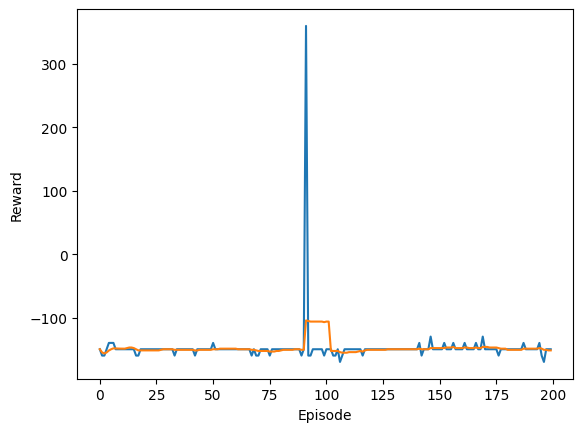

#### Test Results:


##### Hyperparameters:

- Learning rate: 0.0008
- Discount factor (gamma): 0.7
- Epsilon: 1.0
- Epsilon decay: 0.01
- Epsilon min: 0.01
- Batch size: 64
- Memory size: 10000
- Target update frequency: 1/5 (every 5 episodes)
- Number of episodes: 250
- Number of steps per episode: 500
- Number of hidden layers: 2
- Number of neurons in hidden layers: 16, 32
- Activation function: ReLU
- Optimizer: Adam
- Loss function: MSE


In [ ]:
agent.model.save('doublenet_dqn_diff_start_diff_goal_obst.h5')